### They inner atoms, and the outer atoms are equally spaced

In [1]:
from tqdm import tqdm
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os

In [2]:
save_path = r'C:\Users\Leopold\OneDrive - UT Cloud\Uni\Semester_8\BA_mit_Git\BA_Plots\Qutip'
os.makedirs(os.path.dirname(save_path), exist_ok=True)

In [30]:
fixed_lam = 1
fixed_gamma = 1

fixed_dist_in  = 0.3  * fixed_lam
fixed_dist_ext  = 1 * fixed_dist_in
fixed_phi  = 0
fixed_d_hat = np.array([1, 1, 1]) / np.sqrt(3) ### not needed?
########################################                 Define constants                   #############################################
N = 3 + 3 * 5

x_0    = 0.2
x_max  = 1.1

t_max  = 40

phi_0    = 0
phi_max  = 2 * np.pi / 3

phi_size = 20
x_size   = 50
t_size   = 100


########################################################################################################################    
phis   = np.linspace(phi_0, phi_max, phi_size)
dists  = np.linspace(x_0, x_max, x_size) * fixed_lam
times  = np.linspace(0, t_max, t_size) * fixed_gamma

[[-1.67320508  0.          0.        ]
 [-1.37320508  0.          0.        ]
 [-1.07320508  0.          0.        ]
 [-0.77320508  0.          0.        ]
 [-0.47320508  0.          0.        ]
 [-0.17320508  0.          0.        ]
 [ 0.08660254  0.15        0.        ]
 [ 0.08660254 -0.15        0.        ]
 [ 0.23660254  0.40980762  0.        ]
 [ 0.23660254 -0.40980762  0.        ]
 [ 0.38660254 -0.66961524  0.        ]
 [ 0.38660254  0.66961524  0.        ]
 [ 0.53660254 -0.92942286  0.        ]
 [ 0.53660254  0.92942286  0.        ]
 [ 0.68660254  1.18923048  0.        ]
 [ 0.68660254 -1.18923048  0.        ]
 [ 0.83660254  1.44903811  0.        ]
 [ 0.83660254 -1.44903811  0.        ]]


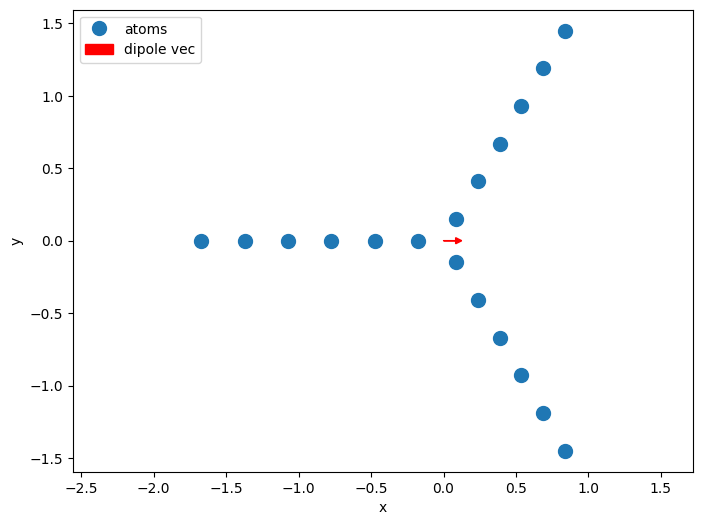

In [31]:
########################################               define the geometry                 #############################################
def dipole_vector(phi = fixed_phi):
    """Returns the dipole vector given its orientation by angle phi."""
    dipole = np.array([np.cos(phi), np.sin(phi), 0])
    return dipole

def atom_positions(d_in = fixed_dist_in, d_ext = fixed_dist_ext, N = N):
    """ Returns     np.ndarray: Positions of the six atoms as a Nx3 array. """
    Pos = np.zeros((N, 3))

    # Calculate the inner triangle vertices (atoms 2, 3, 4)
    cos = np.cos(2 * np.pi / 6) # 60 degrees in radians
    sin = np.sin(2 * np.pi / 6) # 60 degrees in radians
    x = d_in / (2 * np.cos(np.pi / 6)) # 30 deg
    Pos[0] = (- x, 0, 0)
    Pos[1] = (+ x * cos, + x * sin, 0)
    Pos[2] = (+ x * cos, - x * sin, 0)

    for i in range((N-1) // 3):
        Pos[3 * (i+1)] = Pos[0]     + (- (i+1) * d_ext, 0, 0)
        Pos[3 * (i+1) + 1] = Pos[1] + (+ (i+1) * d_ext * cos, + (i+1) * d_ext * sin, 0)
        Pos[3 * (i+1) + 2] = Pos[2] + (+ (i+1) * d_ext * cos, - (i+1) * d_ext * sin, 0)
        
    Pos_sorted = Pos[Pos[:, 0].argsort()]

    return Pos_sorted

positions = atom_positions(fixed_dist_in, fixed_dist_in)
print(positions)
d_hat = dipole_vector()
max_x = np.max(positions[:, 0])
scale = 0.1 * max_x
# Plot the atom positions
plt.figure(figsize=(8, 6))
plt.plot(positions[:, 0], positions[:, 1], 'o', markersize=10, label='atoms')
plt.arrow(0, 0, d_hat[0] * scale, d_hat[1] * scale, 
          head_width=0.5*scale, head_length=0.5*scale, fc='r', ec='r', label='dipole vec')
# Plot dipole vectors
#for i, position in enumerate(positions):
#    plt.arrow(position[0], position[1], d_hat[0] * scale, d_hat[1] * scale, 
#              head_width=0.2*scale, head_length=0.2*scale, fc='r', ec='r')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.axis('equal')
plt.show()

In [32]:
########################################             create the Hamiltonean                 ################################################# old version also down at the bottom
#implement the Greenstensor for the different orientations of the dipole vectors
def Green_tensor(r_a, r_b, k_a):
    r_ab = r_b - r_a
    abs_r_ab = np.linalg.norm(r_ab)
    kappa = k_a * abs_r_ab
    Greenstensor = (np.exp(1j * kappa) / (4 * np.pi * kappa ** 2 * abs_r_ab)
                    * ((kappa ** 2 + 1j * kappa - 1) * np.eye(3)
                       + (- kappa ** 2 - 3 * 1j * kappa + 3)
                       * np.outer(r_ab, r_ab) / (abs_r_ab ** 2)))
    return Greenstensor

def Gamma_coefficients(r_a, r_b,
                       d_a = dipole_vector(), 
                       d_b = dipole_vector(),
                       lam = fixed_lam,
                       gamma = fixed_gamma) -> float:

    if np.linalg.norm(r_b - r_a) < 1e-5:
        return gamma
    k_a = 2 * np.pi / lam
    result = (6 * np.pi * gamma / k_a  # also / d^2 but it has length 1
              * np.matmul(np.conj(d_a), np.matmul(Green_tensor(r_a, r_b, k_a), d_b.T)))
    return np.imag(result)

def V_coefficients(r_a, r_b,
                   d_a = dipole_vector(), 
                   d_b = dipole_vector(),
                   lam = fixed_lam,
                   gamma = fixed_gamma) -> float:
    
    if np.linalg.norm(r_b - r_a) < 1e-5:
        return 0
    k_a = 2 * np.pi / lam
    result = (-3 * np.pi * gamma / k_a # also / d^2 but it has length 1
              * np.matmul(np.conj(d_a), np.matmul(Green_tensor(r_a, r_b, k_a), d_b.T)))
    return np.real(result)

def H_eff(distance_in: float = fixed_dist_in,
          distance_ext: float = fixed_dist_ext,
          d_a = dipole_vector(), 
          d_b = dipole_vector(),
          lam = fixed_lam,
          gamma: float = fixed_gamma,
          N: int = N):
    
    positions  = atom_positions(distance_in, distance_ext)
    H_eff_matrix = np.zeros((N, N), dtype=complex)

    for a in range(N):
        for b in range(N):
            r_a = positions[a]
            r_b = positions[b]

            V_ab = V_coefficients(r_a, r_b, d_a, d_b, lam, gamma)
            Gamma_ab = Gamma_coefficients(r_a, r_b, d_a, d_b, lam, gamma)

            matrix_element = V_ab - 1j * 0.5 * Gamma_ab
            H_eff_matrix[a, b] = matrix_element
    return Qobj(H_eff_matrix)
H = H_eff()
H

Quantum object: dims=[[18], [18]], shape=(18, 18), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 0.        -5.00000000e-01j -0.33229883-3.43465365e-01j
   0.0846859 -6.89302908e-02j  0.02086089+4.28250986e-02j
  -0.02617573+4.82540043e-03j  0.00179175-1.68868639e-02j
   0.01182648+2.78848628e-03j  0.01182648+2.78848628e-03j
  -0.00060911+9.90089828e-03j -0.00060911+9.90089828e-03j
  -0.0089044 -1.49229678e-03j -0.0089044 -1.49229678e-03j
   0.00317148-8.79650454e-03j  0.00317148-8.79650454e-03j
   0.00881822+4.95100199e-03j  0.00881822+4.95100199e-03j
  -0.00669176+8.51265162e-03j -0.00669176+8.51265162e-03j]
 [-0.33229883-3.43465365e-01j  0.        -5.00000000e-01j
  -0.33229883-3.43465365e-01j  0.0846859 -6.89302908e-02j
   0.02086089+4.28250986e-02j -0.02617573+4.82540043e-03j
  -0.0008459 -1.75601787e-02j -0.0008459 -1.75601787e-02j
   0.01356431-1.90165615e-03j  0.01356431-1.90165615e-03j
  -0.00065949+1.23113643e-02j -0.00065949+1.23113643e-02j
  -0.01219645-3.60273430e-0

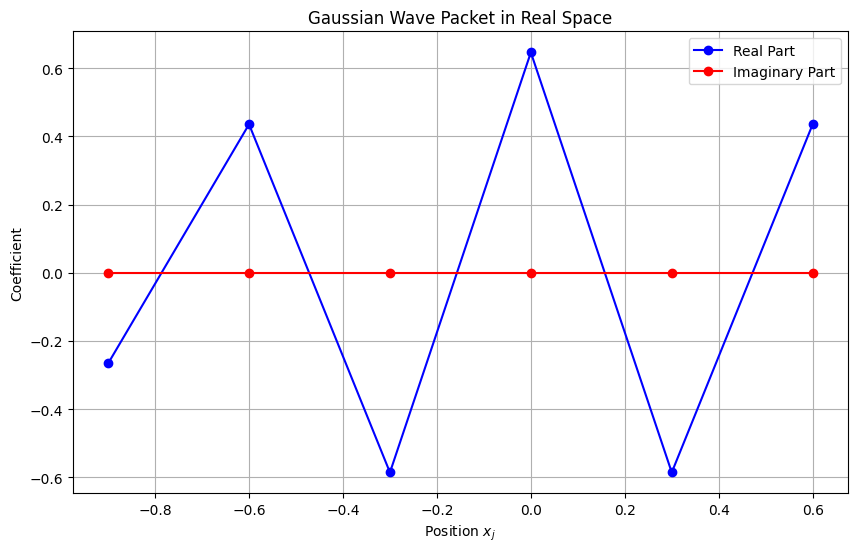

Quantum object: dims=[[18], [1]], shape=(18, 1), type='ket', dtype=Dense
Qobj data =
[[-0.21331237]
 [ 0.34940715]
 [-0.46980889]
 [ 0.51854252]
 [-0.46980889]
 [ 0.34940715]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]

In [33]:
################ initiate Wave-packet
k_s = np.pi / fixed_dist_ext
sigma = 0.1 * k_s
kd_range = np.arange(0, N) * 2 * np.pi / (N * fixed_dist_ext)
center_index = N // 6
x_j = (np.arange(N//3) - center_index) * fixed_dist_ext

# Calculate the Gaussian wave packet in real space
coefficients = np.sqrt(sigma / np.sqrt(2 * np.pi)) * np.exp(-1j * k_s * x_j) * np.exp(-sigma**2 * x_j**2)
wave_packet = sum(coeff * basis(N, j) for j, coeff in enumerate(coefficients))
psi0 = wave_packet.unit()

# Plot the real and imaginary parts of the wave packet coefficients
plt.figure(figsize=(10, 6))
plt.plot(x_j, coefficients.real, 'bo-', label='Real Part')
plt.plot(x_j, coefficients.imag, 'ro-', label='Imaginary Part')
plt.xlabel('Position $x_j$')
plt.ylabel('Coefficient')
plt.title('Gaussian Wave Packet in Real Space')
plt.legend()
plt.grid(True)
plt.show()
Psi_01 = (basis(N,0)-basis(N,1)).unit()
psi0

In [8]:
def total_phases(distances, phis, N = N):
    total_ps = np.zeros((len(distances), len(phis)))
    for i, distance in enumerate(tqdm(distances, desc='Iteration')):
        for j, phi in enumerate(phis):
            dist_in = distance
            dist_ext = 0.10 * dist_in
            H = H_eff(distance_in=dist_in,distance_ext=dist_ext, d_a = dipole_vector(), d_b = dipole_vector(phi), lam = fixed_lam, gamma=fixed_gamma, N=N)
            p = (np.angle(H[N//3 - 1, N//3]) +
                 np.angle(H[N//3 - 1, N//3+1]) +
                 np.angle(H[N//3, N//3+1])) / np.pi
            total_ps[i, j] = p
    return total_ps
#phases = total_phases(dists, phis)

NameError: name 'phases' is not defined

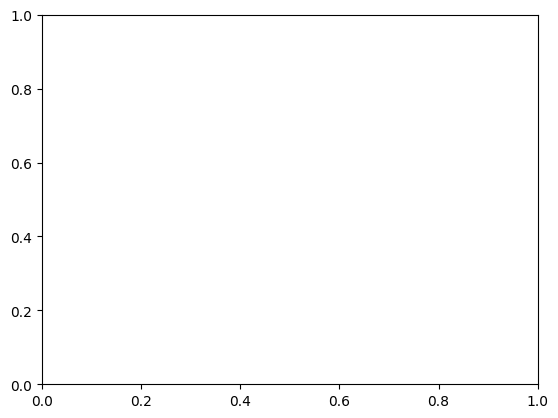

In [9]:
# Create the animation
fig, ax = plt.subplots()
line, = ax.plot(dists, phases[:, 0])

def update(frame):
    line.set_ydata(phases[:, frame])
    ax.set_title(f'angle of dipole vec: phi = {phis[frame]:.2f}')
    ax.set_xlabel(f'total phase along the loop ')
    ax.set_ylabel(f'distance x / lambda')
    return line,

ani = animation.FuncAnimation(fig, update, frames=len(phis), blit=True)
#ani.save(save_path + r'\phases_vs_distance_for_different_dipoles_1.gif', writer='pillow')
plt.show()

[array([1., 0., 0.]),
 array([1., 0., 0.]),
 array([1., 0., 0.]),
 array([1., 0., 0.]),
 array([1., 0., 0.]),
 array([1., 0., 0.]),
 array([1., 0., 0.]),
 array([1., 0., 0.]),
 array([1., 0., 0.])]

0.015899132832595204
0.015899132832595204
0.015899132832595204
0.015899132832595204
0.015899132832595204
0.015899132832595204
0.015899132832595204
0.015899132832595204
0.015899132832595204
0.015899132832595204
0.015899132832595204
0.015899132832595204
0.015899132832595204
0.015899132832595204
0.015899132832595204
0.015899132832595204
0.015899132832595204
0.015899132832595204
0.015899132832595204
0.015899132832595204
0.015899132832595204
0.015899132832595204
0.015899132832595204
0.015899132832595204
0.015899132832595204
0.015899132832595204
0.015899132832595204
0.015899132832595204
0.015899132832595204
0.015899132832595204
differential_evolution step 1: f(x)= -0.0158991
Polishing solution with 'L-BFGS-B'
0.015899132832595204
0.015899133039479256
0.015899133384029065
0.015899132478313312
0.015899132480828554
0.015899132797304642
0.015899132777477922
0.021364632739485183
0.021364633014927012
0.021364633444379243
0.021364632254707226
0.021364632295603637
0.02136463270305708
0.0213646326778

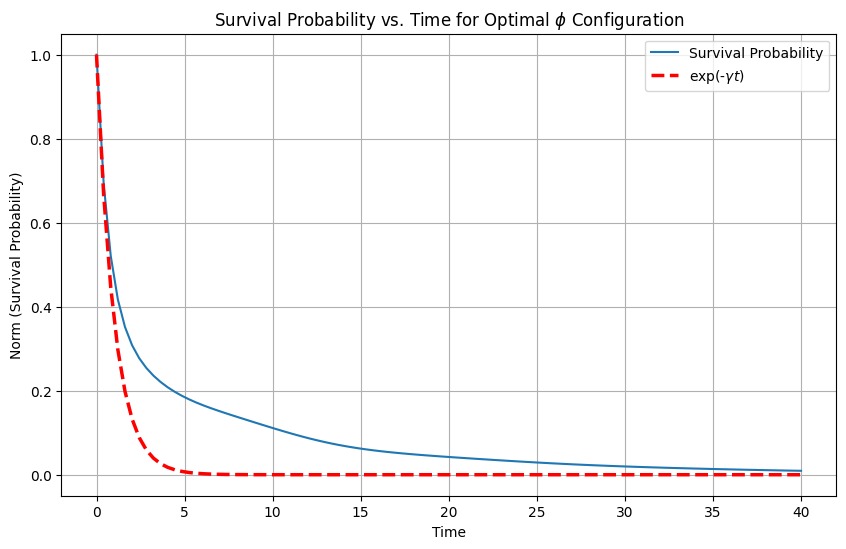

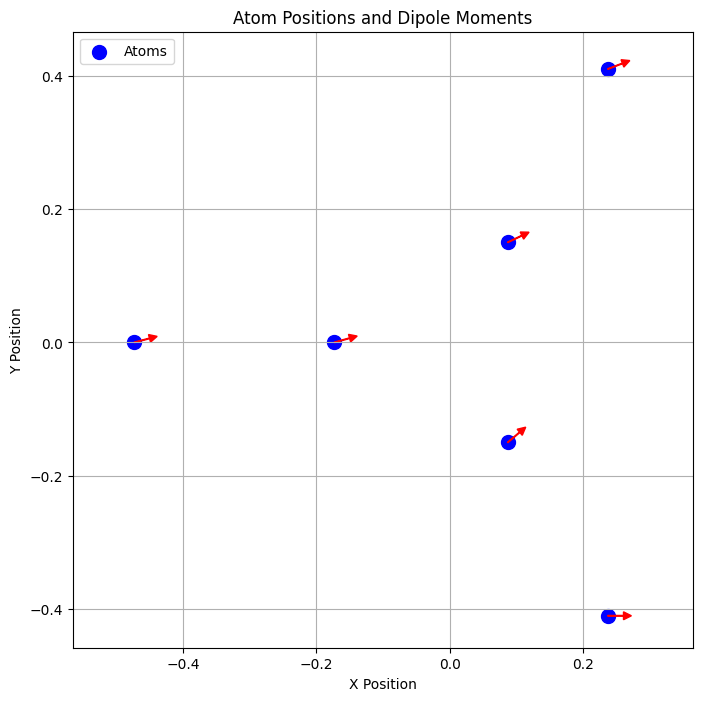

In [10]:
# calculate the optimal phi configuration
from scipy.optimize import differential_evolution

def H_eff_test(distance_in = fixed_dist_in, distance_ext = fixed_dist_ext, dipoles = [dipole_vector() for _ in range(N)], lam=fixed_lam, gamma=fixed_gamma, N=N):
    positions = atom_positions(distance_in, distance_ext, N)
    H_eff_matrix = np.zeros((N, N), dtype=complex)
    for a in range(N):
        for b in range(N):
            r_a = positions[a]
            r_b = positions[b]
            V_ab = V_coefficients(r_a, r_b, dipoles[a], dipoles[b], lam, gamma)
            Gamma_ab = Gamma_coefficients(r_a, r_b, dipoles[a], dipoles[b], lam, gamma)
            matrix_element = V_ab - 1j * 0.5 * Gamma_ab
            H_eff_matrix[a, b] = matrix_element
    return Qobj(H_eff_matrix)

def norms_cal(times, distance_in = fixed_dist_in, distance_ext = fixed_dist_ext, gamma=fixed_gamma, dipoles=[dipole_vector() for _ in range(N)], Psi_0=basis(N, 0)):
    H = H_eff_test(distance_in = distance_in, distance_ext = distance_ext, dipoles=dipoles, lam=fixed_lam, gamma=gamma, N=N)
    all_norms = []
    for t in times:
        U = (-1j * H * t).expm()
        Psi_t = U * Psi_0
        norm_sq = Psi_t.norm()**2
        print(norm_sq)
        all_norms.append(norm_sq)
    return np.array(all_norms)

# Define the cost function to be minimized (negative of the survival probability at t=10*gamma)
def cost_function(phis):
    dipoles = [dipole_vector(phi) for phi in phis]
    survival_probabilities = norms_cal([times[t_size//2]], dipoles=dipoles, Psi_0=psi0)
    survival_probability = survival_probabilities[0]
    return -survival_probability

# Define the bounds for each phi value
bounds = [(0, 2 * np.pi) for _ in range(N)]

############################################################################################ uncomment here
# Define the custom initial population 
def custom_initial_population(N):
    init_pop = np.zeros(N)
    init_pop[N//3:] = np.tile([np.pi/3, -np.pi/3], (N - N//3) // 2)
    return init_pop

# Create the initial population with differential_evolution initialization
def differential_evolution_with_custom_init():
    popsize = 15
    mutation = (0.5, 1)
    recombination = 0.7
    maxiter = 1000
    tol = 0.01

    strategy = 'best1bin'
    init = 'latinhypercube'
    seed = None

    initial_pop = np.array([custom_initial_population(N) for _ in range(popsize)])

    def custom_callback(xk, convergence):
        pass  # Define any custom callback logic here if needed

    result = differential_evolution(
        cost_function,
        bounds,
        strategy=strategy,
        maxiter=maxiter,
        popsize=popsize,
        tol=tol,
        mutation=mutation,
        recombination=recombination,
        seed=seed,
        callback=custom_callback,
        disp=True,
        polish=True,
        init=initial_pop
    )
    return result
result = differential_evolution_with_custom_init() # Perform the optimization
############################################################################################ uncomment here ''' ''' 
#result = differential_evolution(cost_function, bounds)
optimal_phis = result.x
optimal_survival_probability = -result.fun

print(f"Optimal phis: {optimal_phis}")
print(f"Optimal survival probability: {optimal_survival_probability}")

optimal_dipoles = [dipole_vector(phi) for phi in optimal_phis]

# Calculate norms over the entire time range
norms = norms_cal(times, dipoles=optimal_dipoles)
print(norms)
# Plot the norms against time
plt.figure(figsize=(10, 6))
plt.plot(times, norms, label='Survival Probability')
plt.plot(times, np.exp(-times), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')
plt.xlabel('Time')
plt.ylabel('Norm (Survival Probability)')
plt.title('Survival Probability vs. Time for Optimal $\phi$ Configuration')
plt.legend()
plt.grid(True)
plt.show()

# Plot atoms with their dipole moments
positions = atom_positions(fixed_dist_in, fixed_dist_ext, N)
max_x = np.max(positions[:, 0])
scale = 0.1 * max_x

plt.figure(figsize=(8, 8))
plt.scatter(positions[:, 0], positions[:, 1], color='blue', s=100, label='Atoms')
for i in range(N):
    plt.arrow(positions[i, 0], positions[i, 1], optimal_dipoles[i][0] * scale, optimal_dipoles[i][1] * scale, head_width=0.5 * scale, head_length=0.5 * scale, fc='red', ec='red')

plt.title('Atom Positions and Dipole Moments')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.show()

In [11]:
print(result)
x = [ 1.456e-01,  9.890e-02,  1.573e-01,  2.857e-01,  8.069e-01, 3.316e-01,  0.000e+00,  2.485e-01,  1.688e-01]
def cost_function(phis):
    dipoles = [dipole_vector(phi) for phi in phis]
    survival_probabilities = norms_cal([10 * fixed_gamma], dipoles=dipoles, Psi_0=psi0)
    survival_probability = survival_probabilities[0]
    return -survival_probability
cost_function(x)

 message: Optimization terminated successfully.
 success: True
     fun: -0.138086556618711
       x: [ 2.579e-01  2.719e-01  4.439e-01  7.034e-01  3.668e-01
            0.000e+00]
     nit: 1
    nfev: 156
     jac: [-6.495e-07 -6.745e-07  7.938e-07 -1.527e-07 -1.887e-07
            3.453e-02]
0.21068130975864943


-0.21068130975864943

In [34]:
def survival_probability(dipoles, times, Psi_0, distance_in=fixed_dist_in, distance_ext=fixed_dist_ext, lam=fixed_lam, gamma=fixed_gamma, N=N):
    dipoles = dipoles.reshape((N, 3))
    H = H_eff_test(distance_in, distance_ext, dipoles, lam, gamma, N)
    U = (-1j * H * times[len(times) // 2]).expm()
    Psi_t = U * Psi_0
    norm_sq = (Psi_t.norm())**2
    return norm_sq

# Define an optimization function that returns the negative of survival probability
def optimization_target(dipoles_flat):
    dipoles = dipoles_flat.reshape((N, 3))
    return -survival_probability(dipoles, times, psi0)

# Initial guess for the dipole orientations (flattened array)
initial_dipoles = np.array([dipole_vector() for _ in range(N)]).flatten()

from scipy.optimize import minimize
# Constraint to ensure each dipole vector remains a unit vector
def unit_vector_constraint(dipoles_flat):
    dipoles = dipoles_flat.reshape((N, 3))
    return np.array([np.linalg.norm(dipole) - 1 for dipole in dipoles])

# Define the constraints
constraints = [{'type': 'eq', 'fun': unit_vector_constraint}]

# Optimize
result = minimize(optimization_target, initial_dipoles, method='SLSQP', constraints=constraints)

# Extract the optimal dipoles
optimal_dipoles_flat = result.x
optimal_dipoles = optimal_dipoles_flat.reshape((N, 3))

print("Optimal Dipoles:", optimal_dipoles)

Optimal Dipoles: [[ 0.75392759 -0.2314184  -0.6148494 ]
 [ 0.88530568 -0.15564672 -0.4381893 ]
 [ 0.92342486 -0.11990982 -0.36456863]
 [ 0.94218982 -0.09661842 -0.32084962]
 [ 0.95044035 -0.07917837 -0.30065771]
 [ 0.94859199 -0.06275106 -0.31021908]
 [ 0.81162065 -0.50523416 -0.29327709]
 [ 0.75759243  0.48009765 -0.44223501]
 [ 0.15325812 -0.98815882  0.01010342]
 [-0.11000677  0.94153968 -0.31845605]
 [ 0.54710047 -0.68710462  0.47815991]
 [ 0.95503814  0.29617968 -0.01411267]
 [ 0.73451251 -0.5649263   0.37625267]
 [ 0.85942322  0.45613747 -0.23108291]
 [ 0.99503921  0.0275001   0.09561434]
 [ 0.94254518 -0.32684369  0.06916379]
 [ 0.99097841 -0.10797966 -0.07938814]
 [ 0.99893036 -0.00859453 -0.04544315]]


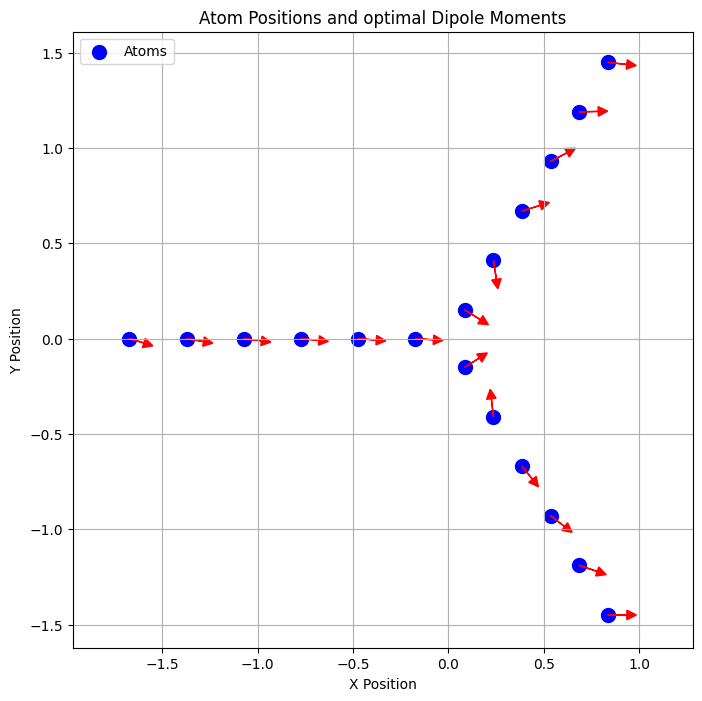

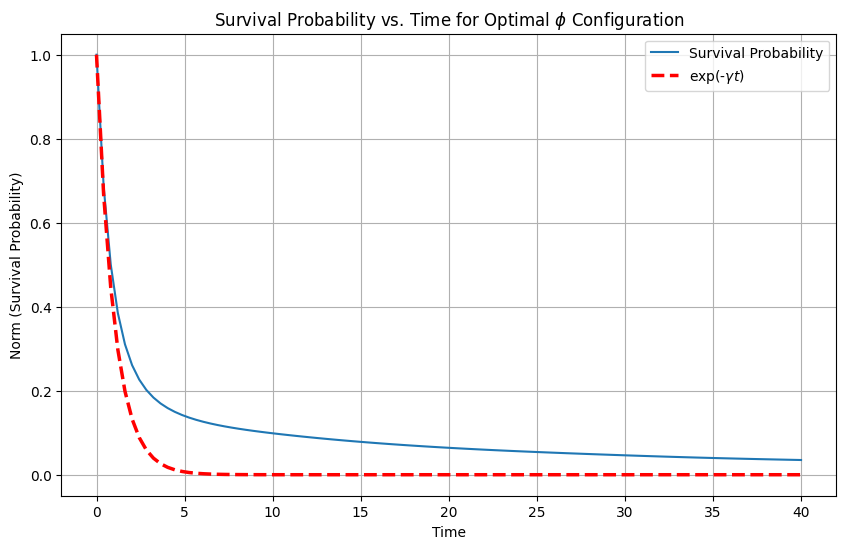

In [35]:
# Plot atoms with their dipole moments
positions = atom_positions(fixed_dist_in, fixed_dist_ext, N)
max_x = np.max(positions[:, 0])
scale = 0.1 * max_x
plt.figure(figsize=(8, 8))
plt.scatter(positions[:, 0], positions[:, 1], color='blue', s=100, label='Atoms')
for i in range(N):
    plt.arrow(positions[i, 0], positions[i, 1], optimal_dipoles[i][0] * 0.1, optimal_dipoles[i][1] * 0.1, head_width=0.5 * 0.1, head_length=0.5 * 0.1, fc='red', ec='red')
plt.title('Atom Positions and optimal Dipole Moments')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.show()

def norms_cal(times, distance_in=fixed_dist_in, distance_ext=fixed_dist_ext, gamma=fixed_gamma, dipoles=[dipole_vector() for _ in range(N)], Psi_0=basis(N, 0)):
    H = H_eff_test(distance_in=distance_in, distance_ext=distance_ext, dipoles=dipoles, lam=fixed_lam, gamma=gamma, N=N)
    all_norms = []
    for t in times:
        U = (-1j * H * t).expm()
        Psi_t = U * Psi_0
        norm_sq = Psi_t.norm()**2
        all_norms.append(norm_sq)
#        if t < .1:
#            print(t, H, U, Psi_t, norm_sq)
    return np.array(all_norms)
norms = norms_cal(times, dipoles=optimal_dipoles)
#print(norms)
# Plot the norms against time
plt.figure(figsize=(10, 6))
plt.plot(times, norms, label='Survival Probability')
plt.plot(times, np.exp(-times), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')
plt.xlabel('Time')
plt.ylabel('Norm (Survival Probability)')
plt.title('Survival Probability vs. Time for Optimal $\phi$ Configuration')
plt.legend()
plt.grid(True)
plt.show()

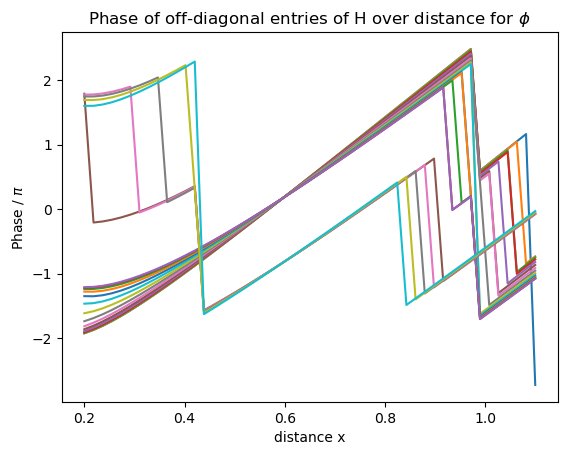

In [48]:
# plot phi(distances for a dipole orientation)
fig, ax = plt.subplots()
plt.plot(dists, phases, label=r'total Phase/ $\pi$')
plt.xlabel(r'distance x')
plt.ylabel(r'Phase / $\pi$')
plt.title(f'Phase of off-diagonal entries of H over distance for $\phi$')#={fixed_phi:.2f}
#plt.legend()
plt.show()

# old implementation

In [34]:
########################################             create the Hamiltonean                 ################################################# old version
#jetzt direkter weg zur NxN matrix
def H_eff(N: int,
          distance_in: float = fixed_dist_in, 
          distance_ext: float = fixed_dist_ext, 
          phi: float = fixed_phi,
          gamma: float = fixed_gamma):

    d_hat = dipole_vector(phi)
    H_eff_matrix = np.zeros((N, N), dtype=complex)
    pos = atom_positions(distance_in, distance_ext, N)

    for i in range(N):
        for j in range(N):
            V_ij = 0
            if i == j:
                Gamma_ij = gamma
            else:
                r_ij = pos[j] - pos[i]
                x = np.linalg.norm(r_ij)
                r_hat_ij = r_ij / x
                k = 2 * np.pi * x
                dot_ij = np.dot(d_hat, r_hat_ij)

                Gamma_ij = 3/2 * gamma * ((1 - (dot_ij)**2) * np.sin(k) / k +
                                          (1 - 3 * (dot_ij)**2) * (np.cos(k)/k**2 -
                                                                   np.sin(k) / k**3))

                V_ij = - 3/4 * gamma * ((1 - (dot_ij)**2) * np.cos(k) / k -
                                        (1 - 3 * (dot_ij)**2) * (np.sin(k)/k**2 +
                                                                 np.cos(k) / k**3))

            matrix_element = V_ij - 1j * 0.5 * Gamma_ij
            H_eff_matrix[i, j] = matrix_element
            
#            self._Gamma = matrix_element.imag  ???????
    return Qobj(H_eff_matrix)
H_ex = H_eff(N)
H_ex

Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 0.        -0.5j        -0.00604716+0.03799544j -0.00064916+0.01036299j
  -0.00064916+0.01036299j  0.0044114 +0.01067949j  0.0044114 +0.01067949j]
 [-0.00604716+0.03799544j  0.        -0.5j        -0.03362103+0.02374715j
  -0.03362103+0.02374715j -0.02723902+0.01523052j -0.02723902+0.01523052j]
 [-0.00064916+0.01036299j -0.03362103+0.02374715j  0.        -0.5j
  -0.11634263-0.01899772j -0.08876876-0.00474943j -0.05382888+0.02009805j]
 [-0.00064916+0.01036299j -0.03362103+0.02374715j -0.11634263-0.01899772j
   0.        -0.5j        -0.05382888+0.02009805j -0.08876876-0.00474943j]
 [ 0.0044114 +0.01067949j -0.02723902+0.01523052j -0.08876876-0.00474943j
  -0.05382888+0.02009805j  0.        -0.5j         0.00237123+0.04355261j]
 [ 0.0044114 +0.01067949j -0.02723902+0.01523052j -0.05382888+0.02009805j
  -0.08876876-0.00474943j  0.00237123+0.04355261j  0.        -0.5j       ]]

In [ ]:
'''def ladder_operator(i, operator_type, N = N):
    if i <= 0 or i > N:
        raise ValueError("Index i out of range. Use 1 <= i <= N")
    if operator_type not in ['lowering', 'raising']:
        raise ValueError("Invalid operator type. Use 'lowering' or 'raising'.")
    if operator_type == 'lowering':
        op_atom = destroy(2)  # Outer product |g⟩⟨e| = ((0,1), (0,0))
    else:
        op_atom = create(2)  # Outer product |e⟩⟨g| = ((0,0), (1,0))
    identity_list = [qeye(2) for _ in range(N)]
    identity_list[i - 1] = op_atom
    op = tensor(identity_list)
    return op

def single_excitation_basis(N = N):
    basis_states = []
    for i in range(N):
        state_list = [basis(2, 0)] * N
        state_list[i] = basis(2, 1)
        basis_state = tensor(state_list)
        basis_states.append(basis_state)
    return basis_states

def generic_superposition(basis_states, coefficients=None):
    N = len(basis_states)
    if coefficients is None:
        coefficients = np.random.rand(N) + 1j * np.random.rand(N)
        coefficients /= np.linalg.norm(coefficients)
    
    superposition = sum(c * state for c, state in zip(coefficients, basis_states))
    return superposition.unit()

def H_eff(distance_in: float = fixed_dist_in,
          distance_ext: float = fixed_dist_ext,
          phi: float = fixed_phi,
          gamma: float = fixed_gamma,
          N: int = N):

    d_hat = dipole_vector(phi)
    pos = atom_positions(distance_in, distance_ext)
    H_V = 0
    H_Gamma = 0
    for i in range(N):
        for j in range(N):
            V_ij = 0
            if i == j:
                Gamma_ij = gamma
            else:
                r_ij = pos[j] - pos[i]
                x = np.linalg.norm(r_ij)
                r_hat_ij = r_ij / x
                k = 2 * np.pi * x
                dot_ij = np.dot(d_hat, r_hat_ij)

                Gamma_ij = 3/2 * gamma * ((1 - (dot_ij)**2) * np.sin(k) / k +
                                          (1 - 3 * (dot_ij)**2) * (np.cos(k)/k**2 -
                                                                   np.sin(k) / k**3))

                V_ij = - 3/4 * gamma * ((1 - (dot_ij)**2) * np.cos(k) / k -
                                        (1 - 3 * (dot_ij)**2) * (np.sin(k)/k**2 +
                                                                 np.cos(k) / k**3))
                
            raising_op_i  = ladder_operator(i+1, 'raising')
            lowering_op_j = ladder_operator(j+1, 'lowering')
                
            H_Gamma += Gamma_ij * (raising_op_i * lowering_op_j)
            H_V     += V_ij     * (raising_op_i * lowering_op_j)

    return H_V - 1/2 * 1j * H_Gamma

def H_eff_red(distance_in: float = fixed_dist_in,
              distance_ext: float = fixed_dist_ext,
              phi: float = fixed_phi,
              gamma: float = fixed_gamma,
              N: int = N):
    
    H = H_eff(distance_in, distance_ext, phi, gamma, N)
    single_exc_basis = single_excitation_basis(N)
    H_reduced = np.zeros((N, N), dtype=complex)

    for i, bra in enumerate(single_exc_basis):
        for j, ket in enumerate(single_exc_basis):
            H_reduced[i, j] = H.matrix_element(bra.dag(), ket)

    return Qobj(H_reduced)
# example form of the Hamiltonean
H_red_ex = H_eff_red()
H_red_ex'''